## Basic SSA in Python example

Ниже приведен пример анализа временного ряда с использованием pyrssa.
Импортируем библиотеки pyrssa, numpy, pandas

In [2]:
import os
os.chdir("..")

In [3]:
import pyrssa as prs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

In [4]:
df = pd.read_csv("examples//tracks_by_date.csv")
df.head()

,Unnamed: 0,Date,Count
0,1,1950-01,4
1,2,1950-02,16
2,3,1950-03,4
3,4,1950-04,17
4,5,1950-05,26


Данные – количество релизов музыкальных композиций по месяцам. Построим временной ряд по всем данным, а затем выберем интересующий нас временной промежуток.

In [5]:
ts_index = pd.date_range(start=df["Date"][1], freq='M', periods=len(df)).strftime('%Y-%m')
ts = pd.Series(df.Count.values, index=ts_index)
ts_recent = ts["2014-01":"2018-01"]
ts_actual = ts["2018-01":"2020-01"]
ts_actual_mspe = ts["2018-02":"2020-01"]

In [6]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.plot(ts)
plt.xticks(ts.index[::120])
plt.show()
plt.plot(ts_recent)
plt.xticks(ts_recent.index[::12])
plt.show()

Далее построим базовое разложение SSA.

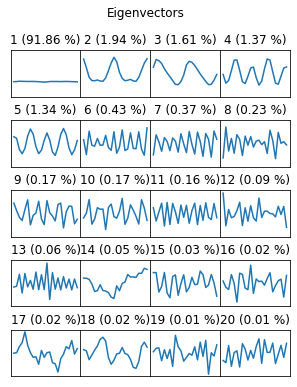

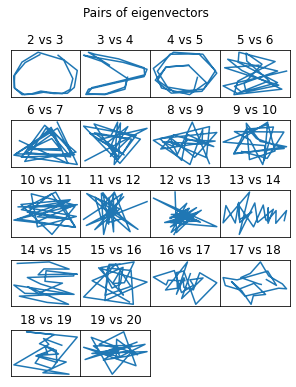

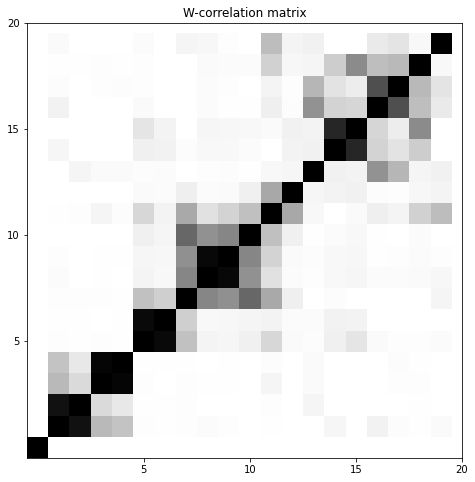

$Trend
   period     rate   |    Mod     Arg  |     Re        Im
      Inf   0.000805 |  1.00081   0.00 |  1.00081   0.00000

$Seasonality
   period     rate   |    Mod     Arg  |     Re        Im
    3.007   0.025242 |  1.02556   2.09 | -0.50815   0.89082
   -3.007   0.025242 |  1.02556  -2.09 | -0.50815  -0.89082
    5.954   0.000502 |  1.00050   1.06 |  0.49326   0.87046
   -5.954   0.000502 |  1.00050  -1.06 |  0.49326  -0.87046
    2.379  -0.002179 |  0.99782   2.64 | -0.87543   0.47883
   -2.379  -0.002179 |  0.99782  -2.64 | -0.87543  -0.47883
    3.928  -0.008625 |  0.99141   1.60 | -0.02858   0.99100
   -3.928  -0.008625 |  0.99141  -1.60 | -0.02858  -0.99100
   11.882  -0.015018 |  0.98509   0.53 |  0.85055   0.49697
  -11.882  -0.015018 |  0.98509  -0.53 |  0.85055  -0.49697
    2.000  -0.560009 |  0.57120   3.14 | -0.57120   0.00000




In [6]:
ts_ssa = prs.ssa(ts_recent, L=len(ts_recent) // 12 // 2 * 12, kind="1d-ssa")
prs.plot(ts_ssa, kind="vectors", idx=np.arange(1, 21))
prs.plot(ts_ssa, kind="paired", idx=np.arange(2, 21), contrib=False)
prs.plot(prs.wcor(ts_ssa, groups=range(1, 21)), scales=range(5, 21, 5))
print(prs.parestimate(ts_ssa, group={"Trend": 1, "Seasonality": range(2, 13)}, method="esprit"))

Для восстановления используем первые 12 компонент в связи с тем, что начиная с 13-й компоненты они начинают заметно смешиваться между собой.

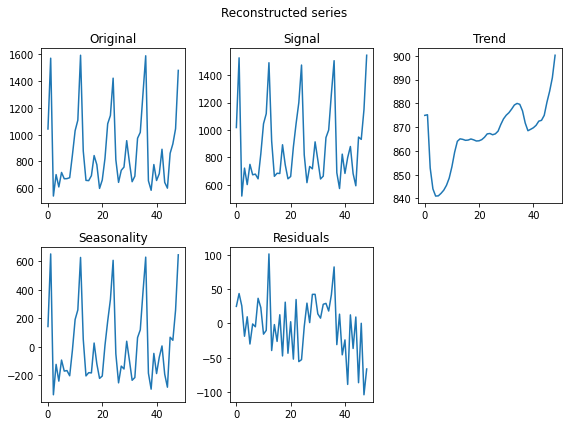

In [7]:
ts_rec = prs.reconstruct(ts_ssa, groups = {"Signal": range(1, 13), "Trend": 1, "Seasonality": range(2, 13)})

prs.plot(ts_rec, layout=(2, 3))

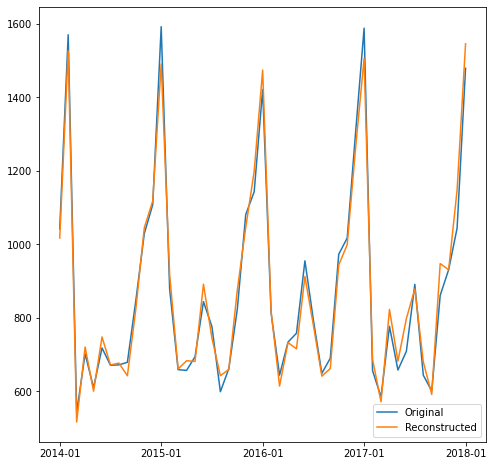

In [8]:
plt.plot(ts_recent, label="Original")
plt.plot(ts_rec.Signal, label = "Reconstructed")
plt.xticks(ts_recent.index[::12])
plt.legend()
plt.show()

Посчитаем ошибку в процентах:

In [9]:
ts_mspe = 100 * np.mean( np.sqrt(( (ts_recent - ts_rec.Signal) / ts_recent )**2)) 
print(ts_mspe)

3.668616948481731


Ошибка составила немногим более 3.5 процентов.

## Recurrent Forecast

Попробуем далее прогнозировать движение временного ряда на небольшом временном промежутке.
В рамках прогнозирования рассмотрим различные подходы, одним из которых является алгоритм рекуррентного прогнозирования.

Данный алгоритм получает на вход длину окна и траекторное пространство, полученное в результате разложения исходного ряда, а также число точек прогноза.

Далее, исходный ряд восстанавливается с помощью процедуры ганкелизации, а прогнозируемые значения получаются с помощью управляющей ЛРФ.

Построим прогноз на 24 значения вперед (на два года).

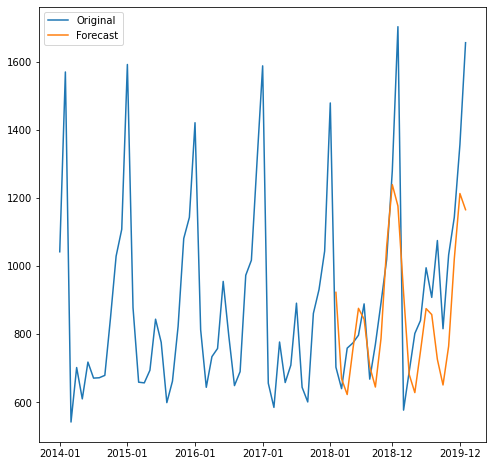

In [10]:
for_length = 24
ts_rfor = prs.rforecast(ts_ssa, groups={"Signal": range(1, 6)}, length = for_length)

ts_rfor_index = pd.date_range(start="2018-2", freq='M', periods=for_length).strftime('%Y-%m')
ts_rfor.Signal = pd.Series(ts_rfor.Signal, index=ts_rfor_index)

ts_original = pd.concat([ts_recent, ts_actual])

plt.plot(pd.concat([ts_recent, ts_actual]), label="Original")
plt.plot(ts_rfor.Signal, label="Forecast")
plt.legend()
plt.xticks(ts_original.index[::12])
plt.show()

Посчитаем ошибку рекуррентного прогноза в процентах:

In [11]:
rfor_mspe = 100 * np.mean( np.sqrt(( (ts_actual_mspe - ts_rfor.Signal) / ts_actual_mspe )**2)) 
print(rfor_mspe)

15.964341561096216


Ошибка составила около 16%

## Vector forecast

Данный алгоритм получает на вход ту же информацию, что и алгоритм рекуррентного прогнозирования, однако его ключевым отличием является то, что операция ганкелизации к полученной матрице сигнала не применяется, а вместо этого прогнозируется вектор, лежащий в полученном траекторном пространстве.

Построим векторый прогноз на два года вперед.

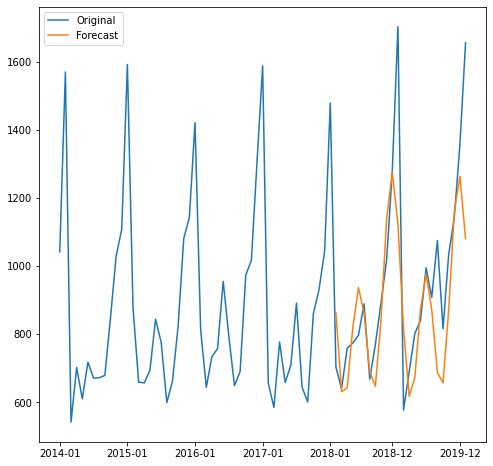

In [12]:
for_length = 24
ts_vfor = prs.vforecast(ts_ssa, groups={"Signal": range(1, 6)}, length = for_length)

ts_vfor_index = pd.date_range(start="2018-2", freq='M', periods=for_length).strftime('%Y-%m')
ts_vfor.Signal = pd.Series(ts_vfor.Signal, index=ts_vfor_index)

ts_original = pd.concat([ts_recent, ts_actual])

plt.plot(pd.concat([ts_recent, ts_actual]), label="Original")
plt.plot(ts_vfor.Signal, label="Forecast")
plt.legend()
plt.xticks(ts_original.index[::12])
plt.show()

Посчитаем ошибку для векторного прогноза:

In [13]:
vfor_mspe = 100 * np.mean( np.sqrt(( (ts_actual_mspe - ts_vfor.Signal) / ts_actual_mspe )**2)) 
print(vfor_mspe)

13.697794062791182


Ошибка составила 13.7% по сравнению с 16% для рекуррентного прогноза.